# Homework 4

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate bonds symbology file `corp_symbology`,
- the cash bond market data file `market_prices_eod`,
- the CDS data file `cds_market_data_eod`. 
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.



In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

# Collection of useful helper functions from previous homeworks

In [2]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule


def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date):
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    day_counter = bond.dayCounter()    
    
    x = [(cf.date(), day_counter.yearFraction(calc_date, cf.date()), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_yearFrac, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowYearFrac': cf_yearFrac, 'CashFlowAmount': cf_amount})

    # filter for payment dates > calc_date
    cashflows_df = cashflows_df[cashflows_df.CashFlowYearFrac > 0]
    return cashflows_df


def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve


def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='term')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['term']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve


def calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads_bps, cds_recovery_rate = 0.4):
    '''Calibrate hazard rate curve from CDS Par Spreads'''
    CDS_settle_days = 2

    CDS_day_count = ql.Actual360()

    # CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              

    CDS_helpers = [ql.SpreadCdsHelper((cds_par_spread / 10000.0), CDS_tenor, CDS_settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, cds_recovery_rate, sofr_yield_curve_handle)
               
    for (cds_par_spread, CDS_tenor) in zip(cds_par_spreads_bps, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
    hazard_rate_curve.enableExtrapolation()

    return(hazard_rate_curve)


# Problem 1: Pricing risky bonds in the hazard rate model
## This is building upon
- Homework 2 "Problem 2: US Treasury yield curve calibration (On-The-Runs)",
- Homework 3 "Problem 3: US SOFR swap curve calibration" and
- Homework 3 "Problem 4: CDS Hazard Rate calibration".

## a. Prepare the market data
### Load the symbology + market data dataframes. Calibrate the following curves as of 2023-04-14:
- the "on-the-run" US Treasury curve,
- the US SOFR curve and 
- the IBM CDS hazard rate curve (on the top of SOFR discount curve).


In [3]:
# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

calc_date_str = '2023-04-14'

In [4]:
###################################################
# Prepare the "on-the-run" US Treasury dataframe
###################################################

# govt_symbology_df
govt_symbology_df = pd.read_excel('../data/govt_symbology.xlsx')
govt_symbology_df.set_index('figi',inplace=True)

# govt_otr_df
govt_otr_df = pd.read_excel('../data/govt_on_the_run.xlsx')
govt_otr_df.set_index('ticker',inplace=True)

# filter for on_the_run_tsy_tickers
on_the_run_tsy_tickers = ['GT2 Govt', 'GT3 Govt', 'GT5 Govt', 'GT7 Govt', 'GT10 Govt', 'GT20 Govt', 'GT30 Govt']
on_the_run_tsy_figis = govt_otr_df.loc[on_the_run_tsy_tickers]['figi']

# govt_otr_symbology_df
govt_otr_symbology_df = govt_symbology_df.loc[on_the_run_tsy_figis]
# print(govt_otr_symbology_df)

# market_prices_df
market_prices_df = pd.read_excel('../data/market_prices_eod.xlsx')
market_prices_df.set_index('date',inplace=True)

# treasury_otr_df
treasury_otr_df = govt_otr_symbology_df.merge(market_prices_df.loc[calc_date_str], how='left', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])


           figi          security       bid       ask  bid_yield  bid_yield
0  BBG01G14BXX2  T 3 7/8 03/31/25   99.5703   99.5820      4.105      4.105
1  BBG01G5ZMM43  T 3 3/4 04/15/26   99.7578   99.7734      3.836      3.836
2  BBG01G14BW91  T 3 5/8 03/31/28  100.0703  100.0859      3.609      3.609
3  BBG01G14BV75  T 3 5/8 03/31/30  100.3750  100.4375      3.563      3.563
4  BBG01DVKBC66  T 3 1/2 02/15/33   99.8438   99.8906      3.519      3.519
5  BBG01F6N6GN1  T 3 7/8 02/15/43  100.2969  100.3750      3.853      3.853
6  BBG01DVKBH56  T 3 5/8 02/15/53   97.9531   98.0313      3.739      3.739


In [5]:
###################################################
# Load SOFR symbology and market data quotes
###################################################

# sofr_symbology_df
sofr_symbology_df = pd.read_excel('../data/sofr_swaps_symbology.xlsx')

# sofr_market_quotes_df
sofr_market_quotes_df = pd.read_excel('../data/sofr_swaps_market_data_eod.xlsx')
sofr_market_quotes_df.set_index('date',inplace=True)
sofr_market_quotes_df.columns = ['figi', 'mid_rate']
# print(sofr_market_quotes_df.tail())

# sofr_df
sofr_df = sofr_symbology_df.merge(sofr_market_quotes_df.loc[calc_date_str], how='left', on=['figi'])
print(sofr_df[['figi', 'name', 'mid_rate']])


           figi                      name  mid_rate
0  BBG00KFWPJJ9   USD OIS  ANN VS SOFR 1Y   4.81290
1  BBG00KFWPJX3   USD OIS  ANN VS SOFR 2Y   4.11450
2  BBG00KFWPK15   USD OIS  ANN VS SOFR 3Y   3.73035
3  BBG00KFWPK51   USD OIS  ANN VS SOFR 5Y   3.38865
4  BBG00KFWPK79   USD OIS  ANN VS SOFR 7Y   3.26475
5  BBG00KFWPKB4  USD OIS  ANN VS SOFR 10Y   3.21550
6  BBG00KFWPKF0  USD OIS  ANN VS SOFR 20Y   3.20165
7  BBG00KFWPKH8  USD OIS  ANN VS SOFR 30Y   3.02075


In [6]:
# cds_market_quotes_df
cds_market_quotes_df = pd.read_excel('../data/cds_market_data_eod.xlsx')
cds_market_quotes_df.set_index('date',inplace=True)
# print(cds_market_quotes_df.head())

# Create par spreads (bps) dataframe
par_spread_col_names = [f'par_spread_{n}y' for n in [1,2,3,5,7,10]]
cds_market_quotes_df = cds_market_quotes_df[par_spread_col_names].apply(lambda x: x*1e4)


In [7]:
# tsy_yield_curve calibration
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)


# sofr_yield_curve calibration
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)


# hazard_rate_curve calibration (from IBM CDS par spreads)
cds_par_spreads = list(cds_market_quotes_df.loc[calc_date_str])
cds_recovery_rate = 0.4

# hazard_rate_curve
hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads, cds_recovery_rate)
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

## b. Create the IBM risky bond objects
### Identify the following 3 IBM fixed rate bonds in the symbology table and create the corresponding fixed rate bonds (3 bond objects).

- security = 'IBM 3.3 05/15/26' / figi = 'BBG00P3BLH05'
- security = 'IBM 3.3 01/27/27' / figi = 'BBG00FVNGFP3'
- security = 'IBM 3 1/2 05/15/29' / figi = 'BBG00P3BLH14'

Use the create_bond_from_symbology() function (discussed in from Homework 2, Problem 1b) to create the bonds objects.

List the bond cashflows using the get_bond_cashflows() function.



In [8]:
# corp_symbology_df
corp_symbology_df = pd.read_excel('../data/corp_symbology.xlsx')
corp_symbology_df = corp_symbology_df[corp_symbology_df.cpn_type == 'FIXED']
ibm_symbology_df = corp_symbology_df[corp_symbology_df.ticker == 'IBM']

# market_prices_df
market_prices_df = pd.read_excel('../data/market_prices_eod.xlsx')
# market_prices_df.set_index('figi',inplace=True)

# ibm_df
ibm_df = ibm_symbology_df.merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
ibm_df.set_index('figi',inplace=True)

# Keep selected IBM bonds only
ibm_selected_figis = ['BBG00P3BLH05', 'BBG00FVNGFP3', 'BBG00P3BLH14']
ibm_df = ibm_df.loc[ibm_selected_figis]
print(ibm_df.T)


figi                   BBG00P3BLH05         BBG00FVNGFP3         BBG00P3BLH14
ticker                          IBM                  IBM                  IBM
class                          Corp                 Corp                 Corp
isin                   US459200JZ55         US459200JR30         US459200KA85
trace                    IBM4832194           IBM4448403           IBM4832195
und_bench_isin         US91282CGR60         US91282CGT27         US91282CGT27
security           IBM 3.3 05/15/26     IBM 3.3 01/27/27   IBM 3 1/2 05/15/29
name                       IBM CORP             IBM CORP             IBM CORP
type                         GLOBAL               GLOBAL               GLOBAL
coupon                          3.3                  3.3                  3.5
cpn_type                      FIXED                FIXED                FIXED
dcc                          30/360               30/360               30/360
cpn_freq                          2                    2        

In [9]:
# Create ibm_bond_objects
ibm_bond_objects = [ create_bond_from_symbology(df_row.to_dict()) for index, df_row in ibm_df.iterrows()]

# List the bond cashflows
for i in range(0, 3):
    print('Bond cashflows for', ibm_df.iloc[i]['security'])
    print(get_bond_cashflows(ibm_bond_objects[i], calc_date)) 


Bond cashflows for IBM 3.3 05/15/26
           CashFlowDate  CashFlowYearFrac  CashFlowAmount
7        May 15th, 2023          0.086111            1.65
8   November 15th, 2023          0.586111            1.65
9        May 15th, 2024          1.086111            1.65
10  November 15th, 2024          1.586111            1.65
11       May 15th, 2025          2.086111            1.65
12  November 15th, 2025          2.586111            1.65
13       May 15th, 2026          3.086111            1.65
14       May 15th, 2026          3.086111          100.00
Bond cashflows for IBM 3.3 01/27/27
          CashFlowDate  CashFlowYearFrac  CashFlowAmount
12     July 27th, 2023          0.286111            1.65
13  January 27th, 2024          0.786111            1.65
14     July 27th, 2024          1.286111            1.65
15  January 27th, 2025          1.786111            1.65
16     July 27th, 2025          2.286111            1.65
17  January 27th, 2026          2.786111            1.65
18     

## c. Compute CDS-implied (intrinsic) prices for the IBM fixd rate bonds

Price the 3 IBM bonds using the CDS-calibrated hazard rate curve for IBM (via RiskyBondEngine).

Print the clean prices and yields for the 3 test bonds. You can use the example code below.


In [10]:
# flat_recovery_rate
flat_recovery_rate = 0.40

# Risky bond engine uses the calibrated CDS hazard rate curve for pricing credit default risk 
risky_bond_engine = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle)

# Model/intrinsic prices and yields
ibm_model_prices = []
ibm_model_yields = []

# Print the clean prices and yields for the 3 test bonds
for i in range(0, 3):
    fixed_rate_bond = ibm_bond_objects[i]
    fixed_rate_bond.setPricingEngine(risky_bond_engine)
    
    corpBondModelPrice = round(fixed_rate_bond.cleanPrice(), 3)
    corpBondModelYield = round(fixed_rate_bond.bondYield(corpBondModelPrice, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100, 3)

    ibm_model_prices.append(corpBondModelPrice)
    ibm_model_yields.append(corpBondModelYield)
    
    
# Display relevant metrics
ibm_df['model_price'] = ibm_model_prices
ibm_df['model_yield'] = ibm_model_yields
print(ibm_df[['security', 'model_price', 'model_yield']])


                        security  model_price  model_yield
figi                                                      
BBG00P3BLH05    IBM 3.3 05/15/26       97.494        4.176
BBG00FVNGFP3    IBM 3.3 01/27/27       96.910        4.192
BBG00P3BLH14  IBM 3 1/2 05/15/29       96.224        4.210


## d. Compute the "intrinsic" vs market price basis for the IBM bonds

Load the market clean prices and yields (mid quotes) from the market quotes dataframe as of 2023-04-14. Compute the basis between the "CDS-implied intrinsic" vs market values. 

- BasisInPrice = corpBondModelPrice - corpBondMarketPrice
- BasisInYield = corpBondModelYield - corpBondMarketYield


Are the CDS intrinsic prices lower or higher than the bond prices observed on the market? What factors could explain the basis?


In [11]:
# Add market prices
ibm_df['market_price'] = (ibm_df['bid'] + ibm_df['ask']) / 2
ibm_df['market_yield'] = (ibm_df['bid_yield'] + ibm_df['ask_yield']) / 2

# Compute basis
ibm_df['basis_price'] = ibm_df['model_price'] - ibm_df['market_price']
ibm_df['basis_yield'] = ibm_df['model_yield'] - ibm_df['market_yield']

# Display relevant metrics
print(ibm_df[['security', 'market_price', 'model_price', 'basis_price', 'market_yield', 'model_yield', 'basis_yield']])

                        security  market_price  model_price  basis_price   
figi                                                                       
BBG00P3BLH05    IBM 3.3 05/15/26       96.7870       97.494       0.7070  \
BBG00FVNGFP3    IBM 3.3 01/27/27       96.2695       96.910       0.6405   
BBG00P3BLH14  IBM 3 1/2 05/15/29       93.9720       96.224       2.2520   

              market_yield  model_yield  basis_yield  
figi                                                  
BBG00P3BLH05         4.428        4.176       -0.252  
BBG00FVNGFP3         4.382        4.192       -0.190  
BBG00P3BLH14         4.650        4.210       -0.440  


CDS-implied, intrinsic bond prices are higher than bond market prices.

Following factors could explain the basis dislocation for the 3 IBM bonds:
1. Hazard Rate curve mismatch: the synthetic CDS credit market is underestimating the credit risk in the IBM issuer curve, relative to the cash corporate bond market. This opens the opportunity for Bond vs CDS basis arbitrage trades, as discussed in Session 2. 
2. Risk-free yield curve mismatch: the (synthetic) SOFR yield curve is tighter than the (cash) US Treasury curve. This is usually due to a funding differential for cash vs. synthetic products.
3. Temporarily dislocation: Individual bonds are temporarily dislocated from their "fair value" from the issuer curve (e.g. in a Nelson-Siegel type parametric model). This can happen due to buying vs. selling imbalance in that particular bond.
4. Liquidity discounts: in general, less liquid (e.g. off-the-run) bonds trade at a price discount to more liquid (e.g. on-the-run) bonds. This usually causes a liquidty-implied "richer" basis (wider in yield space).

# Problem 2: Compute scenario sensitivities for risky bonds
## a. Compute scenario IR01s for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario IR01 and Durations using a -1bp interest rate shock, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that IR01 = Dirty_Price * Duration.


In [12]:
# Bump interest rate by -1bps (parallel shift)
interest_rate_scenario_1bp_down = ql.SimpleQuote(-0.0001)
tsy_yield_curve_handle_1bp_down = ql.YieldTermStructureHandle(ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, ql.QuoteHandle(interest_rate_scenario_1bp_down)))
risky_bond_engine_1bp_down = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle_1bp_down)

# Bump interest rate by +1bps (parallel shift)
interest_rate_scenario_1bp_up = ql.SimpleQuote(0.0001)
tsy_yield_curve_handle_1bp_up = ql.YieldTermStructureHandle(ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, ql.QuoteHandle(interest_rate_scenario_1bp_up)))
risky_bond_engine_1bp_up = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle_1bp_up)


In [13]:
# Model scenario metrics
ibm_model_prices_1bp_up = []
ibm_model_prices_1bp_down = []
ibm_model_ir01 = []
ibm_model_duration = []
ibm_model_convexity = []

# Model analytic metrics
ibm_model_analytic_duration = []
ibm_model_analytic_convexity = []

# Calculate IR01 and duration
for i in range(0, 3):
    fixed_rate_bond = ibm_bond_objects[i]
    
    # Calc model dirty price for base case
    fixed_rate_bond.setPricingEngine(risky_bond_engine)    
    dirty_price_base = fixed_rate_bond.dirtyPrice()
    
    # Compute analytical duration and convexity (optional metrics)
    bond_yield_rate = ql.InterestRate(ibm_model_yields[i]/100, ql.ActualActual(ql.ActualActual.ISMA), ql.Compounded, ql.Semiannual)
    analytic_duration = ql.BondFunctions.duration(fixed_rate_bond, bond_yield_rate)
    analytic_convexity = ql.BondFunctions.convexity(fixed_rate_bond, bond_yield_rate)

    # Scenario: 1bp down
    fixed_rate_bond.setPricingEngine(risky_bond_engine_1bp_down)    
    price_1bp_down = fixed_rate_bond.cleanPrice()
    ibm_model_prices_1bp_down.append(price_1bp_down)
    
    # Scenario: 1bp up
    fixed_rate_bond.setPricingEngine(risky_bond_engine_1bp_up)
    price_1bp_up = fixed_rate_bond.cleanPrice()
    ibm_model_prices_1bp_up.append(price_1bp_up)

    # Compute scenario delta/gamma sensitivities
    price_base = ibm_model_prices[i]
    ir01 = (price_1bp_down - price_base) * 1e4 / 100
    duration = ir01 / dirty_price_base * 100
    gamma_1bp = (price_1bp_down - 2*price_base + price_1bp_up) * 1e8 / 100
    convexity = gamma_1bp / dirty_price_base * 100

    ibm_model_ir01.append(ir01)
    ibm_model_duration.append(duration)
    ibm_model_convexity.append(convexity)    
    ibm_model_analytic_duration.append(analytic_duration)
    ibm_model_analytic_convexity.append(analytic_convexity)


# Display relevant metrics
ibm_df['IR01'] = ibm_model_ir01
ibm_df['duration'] = ibm_model_duration
ibm_df['analytic_duration'] = ibm_model_analytic_duration
print(ibm_df[['security', 'IR01', 'duration', 'analytic_duration']])


                        security      IR01  duration  analytic_duration
figi                                                                   
BBG00P3BLH05    IBM 3.3 05/15/26  2.861644  2.893576           2.846346
BBG00FVNGFP3    IBM 3.3 01/27/27  3.501088  3.585249           3.478820
BBG00P3BLH14  IBM 3 1/2 05/15/29  5.256227  5.379333           5.316407


## b. Compute scenario Convexities for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Compute the scenario Convexities using the +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.


In [14]:
# Display relevant metrics
ibm_df['convexity'] = ibm_model_convexity
ibm_df['analytic_convexity'] = ibm_model_analytic_convexity
print(ibm_df[['security', 'convexity', 'analytic_convexity']])

                        security   convexity  analytic_convexity
figi                                                            
BBG00P3BLH05    IBM 3.3 05/15/26  -50.414729            9.823037
BBG00FVNGFP3    IBM 3.3 01/27/27  167.150883           14.302625
BBG00P3BLH14  IBM 3 1/2 05/15/29   59.270567           33.104126


One can see that the scenario convexity is not accurate when using +/-1bp bumps. 

This is due to the fact that the convexity bumps are too small relative to the numerical precision of the analytics !

This happens often in paractice, and the way to fix this is to use wider bumps, e.g. +/-10 bps, to better capture the convexity.

In [15]:
# Bump interest rate by -10bps (parallel shift), to better capture convexity !!!
interest_rate_scenario_10bp_down = ql.SimpleQuote(-0.0010)
tsy_yield_curve_handle_10bp_down = ql.YieldTermStructureHandle(ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, ql.QuoteHandle(interest_rate_scenario_10bp_down)))
risky_bond_engine_10bp_down = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle_10bp_down)

# Bump interest rate by +10bps (parallel shift), to better capture convexity !!!
interest_rate_scenario_10bp_up = ql.SimpleQuote(0.0010)
tsy_yield_curve_handle_10bp_up = ql.YieldTermStructureHandle(ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, ql.QuoteHandle(interest_rate_scenario_10bp_up)))
risky_bond_engine_10bp_up = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate, tsy_yield_curve_handle_10bp_up)


In [16]:
# Calculate scenario convexity
ibm_model_prices_10bp_up = []
ibm_model_prices_10bp_down = []
ibm_model_convexity = []

for i in range(0, 3):
    fixed_rate_bond = ibm_bond_objects[i]
    
    # Calc model dirty price for base case
    fixed_rate_bond.setPricingEngine(risky_bond_engine)    
    dirty_price_base = fixed_rate_bond.dirtyPrice()
        
    # Scenario: 10bp down
    fixed_rate_bond.setPricingEngine(risky_bond_engine_10bp_down)    
    price_10bp_down = fixed_rate_bond.cleanPrice()
    ibm_model_prices_10bp_down.append(price_10bp_down)
    
    # Scenario: 10bp up
    fixed_rate_bond.setPricingEngine(risky_bond_engine_10bp_up)
    price_10bp_up = fixed_rate_bond.cleanPrice()
    ibm_model_prices_10bp_up.append(price_10bp_up)

    # Compute scenario delta/gamma sensitivities
    price_base = ibm_model_prices[i]
    gamma_10bp = (price_10bp_down - 2*price_base + price_10bp_up) * 1e6 / 100
    convexity = gamma_10bp / dirty_price_base * 100

    ibm_model_convexity.append(convexity)    


# Display relevant metrics
ibm_df['convexity'] = ibm_model_convexity
print(ibm_df[['security', 'convexity', 'analytic_convexity']])


                        security  convexity  analytic_convexity
figi                                                           
BBG00P3BLH05    IBM 3.3 05/15/26   8.147527            9.823037
BBG00FVNGFP3    IBM 3.3 01/27/27  14.900701           14.302625
BBG00P3BLH14  IBM 3 1/2 05/15/29  31.611894           33.104126


## c. Compute scenario HR01s (hazard rate sensitivity) and CS01s (credit spread sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a -1bp (parallel shift) scenario to the IBM CDS Par Spread quotes and calibrate the scenario hazard rate curve. 

Create a new scenario RiskyBondEngine, using the scenario hazard rate curve.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped hazard rate curve) to obtain the -1bp scenario HR01 (hazard rate sensitivity).

The credit spread sensitivity CS01 is defined as CS01 = (ScenarioPrice - BasePrice) / (ScenarioYield - BasePYield) * 100.

Compute the scenario bond yields and the scenario CS01s for the 3 bonds.


In [17]:
# hazard_rate_curve calibration (from IBM CDS par spreads)
cds_par_spreads_1bp_down = [ps - 1 for ps in cds_par_spreads]
print(cds_par_spreads)
print(cds_par_spreads_1bp_down)

# hazard_rate_curve
hazard_rate_curve_1bp_down = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads_1bp_down, cds_recovery_rate)
default_prob_curve_handle_1bp_down = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve_1bp_down)

# Risky bond engine for CDS Par Spread -1bp scenario
risky_bond_engine_cds_1bp_down = ql.RiskyBondEngine(default_prob_curve_handle_1bp_down, flat_recovery_rate, tsy_yield_curve_handle)


[17.2509, 24.0913, 35.436, 55.579899999999995, 72.516, 79.9212]
[16.2509, 23.0913, 34.436, 54.579899999999995, 71.516, 78.9212]


In [18]:
# Calculate HR01 and CS01
ibm_model_hr01 = []
ibm_model_cs01 = []

for i in range(0, 3):
    fixed_rate_bond = ibm_bond_objects[i]
    price_base = ibm_model_prices[i]
    yield_base = ibm_model_yields[i]
    
    fixed_rate_bond.setPricingEngine(risky_bond_engine_cds_1bp_down)
    
    price_cds_1bp_down = fixed_rate_bond.cleanPrice()
    yield_cds_1bp_down = fixed_rate_bond.bondYield(price_cds_1bp_down, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

    price_diff_cds_1bp_down = price_cds_1bp_down - price_base
    yield_diff_cds_1bp_down = yield_cds_1bp_down - yield_base
    
    ibm_model_hr01.append(- price_diff_cds_1bp_down / yield_diff_cds_1bp_down)
    ibm_model_cs01.append(price_diff_cds_1bp_down * 1e4 / 100)

# Display relevant metrics
ibm_df['HR01'] = ibm_model_hr01
ibm_df['CS01'] = ibm_model_cs01
print(ibm_df[['security', 'HR01', 'CS01']])


                        security      HR01      CS01
figi                                                
BBG00P3BLH05    IBM 3.3 05/15/26  2.846314  2.901598
BBG00FVNGFP3    IBM 3.3 01/27/27  3.508677  3.505292
BBG00P3BLH14  IBM 3 1/2 05/15/29  5.456637  5.334841


## d. Compute scenario Rec01 (recovery rate sensitivity) for the 3 IBM bonds
Use the 3 IBM test bonds defined in Problem 1. 

Apply a +1% scenario bump to the IBM recovery rate (flat_recovery_rate parameter will move from 40% to 41%).

Create a new scenario RiskyBondEngine, using the scenario new recovery rate.

Reprice the risky bonds on the scenario RiskyBondEngine (using the bumped recovery rate) to obtain the +1% scenario REC01 (recovery rate sensitivity).


In [19]:
# Bump recovery rate by 1% up
flat_recovery_rate_1pct_up = flat_recovery_rate + 0.01
risky_bond_engine_rec_1pct_up = ql.RiskyBondEngine(default_prob_curve_handle, flat_recovery_rate_1pct_up, tsy_yield_curve_handle)

# Calculate Rec01
ibm_model_rec01 = []


for i in range(0, 3):
    fixed_rate_bond = ibm_bond_objects[i]
    price_base = ibm_model_prices[i]    
    
    fixed_rate_bond.setPricingEngine(risky_bond_engine_rec_1pct_up)
    
    price_rec_1pct_up = fixed_rate_bond.cleanPrice()    
    
    ibm_model_rec01.append(price_rec_1pct_up - price_base)  

# Display relevant metrics
ibm_df['REC01'] = ibm_model_rec01
print(ibm_df[['security', 'REC01']])


                        security     REC01
figi                                      
BBG00P3BLH05    IBM 3.3 05/15/26  0.016768
BBG00FVNGFP3    IBM 3.3 01/27/27  0.025761
BBG00P3BLH14  IBM 3 1/2 05/15/29  0.057841


# Problem 3: Nelson-Siegel model for smooth hazard rate curves
## Follow Lecture 4, Section 1 "Parametric Hazard Rate Models"
## Follow Section "13. Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the QuantLib Intro V3 notebook
## You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries (GitHub repo link posted in Canvas).

## a. Prepare the market data as of 2023-04-14
Load the symbology + market data dataframes for all Verizon fixed rate bonds (ticker = 'VZ'). 

Calibrate the "on-the-run" US Treasury curve, which will be used as discount factor curve.


In [20]:
# vz_symbology_df
vz_symbology_df = corp_symbology_df[corp_symbology_df.ticker == 'VZ']
# vz_symbology_df = vz_symbology_df[vz_symbology_df['rank'] == 'Sr Unsecured']


# vz_df
vz_df = vz_symbology_df.merge(market_prices_df, how='inner', on=['class', 'ticker', 'isin', 'figi'])
vz_df['market_price'] = vz_df['mid_clean']
vz_df['market_yield'] = (vz_df['bid_yield'] + vz_df['ask_yield']) / 2
vz_df.sort_values('maturity',inplace=True)
print(vz_df.head())


   ticker class          figi          isin      trace und_bench_isin   
40     VZ  Corp  BBG00ZLKTDJ4  US92343VGF58  VZ5148416   US91282CGU99  \
9      VZ  Corp  BBG007DM0XF2  US92343VCR33  VZ4176696   US91282CGU99   
21     VZ  Corp  BBG00JKZK9K4  US92343VEN01  VZ4581325   US91282CGU99   
32     VZ  Corp  BBG00Y4Q8VY9  US92343VFS88  VZ5078182   US91282CGU99   
41     VZ  Corp  BBG00ZLKTF09  US92343VGG32  VZ5148417   US91282CGR60   

             security                    name    type  coupon  ... currency   
40  VZ 0 3/4 03/22/24  VERIZON COMMUNICATIONS  GLOBAL   0.750  ...      USD  \
9   VZ 3 1/2 11/01/24  VERIZON COMMUNICATIONS  GLOBAL   3.500  ...      USD   
21  VZ 3.376 02/15/25  VERIZON COMMUNICATIONS  GLOBAL   3.376  ...      USD   
32   VZ 0.85 11/20/25  VERIZON COMMUNICATIONS  GLOBAL   0.850  ...      USD   
41   VZ 1.45 03/20/26  VERIZON COMMUNICATIONS  GLOBAL   1.450  ...      USD   

         date     bid     ask mid_clean mid_dirty bid_yield ask_yield   
40 2023-04-14

## b. Create the Nelson-Siegel curve shape (4 parameters) and compute the corresponding SSE function.
For a given set of parameters, write a function to compute the SSE "Sum of Squared Errors" penalty function in price space (defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds).


For each bond, compute the bond durations, using Section "9. Analytical Duration" in the QuantLib introductory notebook as a template.

Use 1/Duration as SSE weights. You can ignore the liquidity adjuster for the purpose of this exercise.

In [21]:
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''        
    if(maturity == 0 or params[3] <= 0):
        slope_1 = 1
        curvature = 0
    else:
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
        curvature = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature
    
    return total_value

def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''            
    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]
    
    # cap and floor survival probs
    nelson_siegel_surv_prob_levels = [max(min(x,1),1e-8) for x in nelson_siegel_surv_prob_levels]

    # nelson_siegel_surv_prob_curve
    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)
    
    return(nelson_siegel_credit_curve_handle)


def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # nelson_siegel_surv_prob_curve_handle
    nelson_siegel_surv_prob_curve_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)
    
    # nelson_siegel_risky_bond_engine
    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_surv_prob_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)
    
    bond_model_prices = []
    bond_model_yields = []
    
    for fixed_rate_bond in fixed_rate_bond_objects:
        fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)
        
        bond_price = fixed_rate_bond.cleanPrice()                
        bond_yield = fixed_rate_bond.bondYield(bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
        
        bond_model_prices.append(bond_price)
        bond_model_yields.append(bond_yield)
    
    return(bond_model_prices, bond_model_yields)

def nelson_siegel_sse(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # bond_model_prices
    bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate)
    # sse    
    sse = 0
    
    for i in range(len(market_prices)):
        model_error = market_prices[i] - bond_model_prices[i]                
        sse += model_error * model_error * calib_weights[i]                        
    
    return(sse)    


def create_bonds_and_weights(bond_details, tsy_yield_curve_handle):
    
    # risk_free_bond_engine
    risk_free_bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)


    fixed_rate_bond_objects = []
    bond_market_prices = []    
    bond_yields = []
    bond_DV01s = []    
    bond_durations = []    
    
    for index,row in bond_details.iterrows():
        fixed_rate_bond = create_bond_from_symbology(row)
        fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
        
        fixed_rate_bond_objects.append(fixed_rate_bond)
        
        bond_price = row['market_price']                
        bond_yield = fixed_rate_bond.bondYield(bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
        bond_yield_rate = ql.InterestRate(bond_yield/100, ql.ActualActual(ql.ActualActual.ISMA), ql.Compounded, ql.Semiannual)
        bond_duration = ql.BondFunctions.duration(fixed_rate_bond, bond_yield_rate)
        bond_DV01   = fixed_rate_bond.dirtyPrice() * bond_duration
        
        bond_market_prices.append(bond_price)
        bond_yields.append(bond_yield)
        bond_DV01s.append(bond_DV01)
        bond_durations.append(bond_duration)   
        
    # calib_weights: down-weight durations < 2 years, since the calibrated US treasury does not have quotes before 2Y
    calib_weights = [1 / max(d, 2) for d in bond_durations]
    sum_calib_weights = sum(calib_weights)
    calib_weights = [x / sum_calib_weights for x in calib_weights]
    
    return(fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations)


In [22]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# initial_nelson_siegel_params
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
print('initial_nelson_siegel_params:', initial_nelson_siegel_params)

fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(vz_df, tsy_yield_curve_handle)
vz_df['duration'] = bond_durations
vz_df['calib_weight'] = calib_weights

init_bond_model_prices, init_bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
vz_df['init_model_price'] = init_bond_model_prices
vz_df['init_model_yield'] = init_bond_model_yields
print(vz_df[['security', 'market_price', 'init_model_price', 'calib_weight']].head())

# initial_sse
initial_sse = nelson_siegel_sse(initial_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', initial_sse)


initial_nelson_siegel_params: [0.03, -0.01, 0.02, 5.0]
             security  market_price  init_model_price  calib_weight
40  VZ 0 3/4 03/22/24        96.151         95.809946      0.045628
9   VZ 3 1/2 11/01/24        98.261         96.841448      0.045628
21  VZ 3.376 02/15/25        98.048         96.262144      0.045628
32   VZ 0.85 11/20/25        91.274         89.078877      0.036516
41   VZ 1.45 03/20/26        91.967         89.459038      0.032556
initial_sse = 10.417281362572561


## c. Calibrate the Nelson-Siegel model parameters to obtain the smooth Verizon credit curve.

Minimize the SSE (pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [23]:
from scipy.optimize import minimize

def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):
    # create_bonds_and_weights
    fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(bond_details, tsy_yield_curve_handle)
    
    # start calibration
    param_bounds = [(1e-3, 0.1), (-0.1, 0.1), (-0.1, 0.1), (1e-3, 10)]
            
    calib_results = minimize(nelson_siegel_sse,
                                            initial_nelson_siegel_params, 
                                            args = (calc_date, 
                                                    fixed_rate_bond_objects, 
                                                    bond_market_prices, 
                                                    calib_weights,
                                                    tsy_yield_curve_handle, 
                                                    bond_recovery_rate),
                                            bounds = param_bounds)


    return(calib_results)



In [24]:
# calibrate_nelson_siegel_model
calib_results = calibrate_nelson_siegel_model(initial_nelson_siegel_params, calc_date, vz_df, tsy_yield_curve_handle, bond_recovery_rate)
print(calib_results)
    
# calib_nelson_siegel_params
calib_nelson_siegel_params = calib_results.x
print('calib_nelson_siegel_params:', calib_nelson_siegel_params)

# calib_nelson_siegel_curve
calib_nelson_siegel_curve = create_nelson_siegel_curve(calc_date, calib_nelson_siegel_params)

# calib_sse
calib_sse = nelson_siegel_sse(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, bond_market_prices, calib_weights, tsy_yield_curve_handle, bond_recovery_rate)
print('initial_sse =', round(initial_sse, 3), 'calib_sse =', round(calib_sse, 3))


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.301656061595437
        x: [ 4.273e-02 -5.560e-02 -5.697e-06  2.687e+00]
      nit: 43
      jac: [ 5.675e-03  1.572e-03  1.097e-03 -2.824e-05]
     nfev: 320
     njev: 64
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
calib_nelson_siegel_params: [ 4.27286556e-02 -5.55962225e-02 -5.69656589e-06  2.68673420e+00]
initial_sse = 10.417 calib_sse = 6.302


## d. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding yields.

Plot the model vs market yields (Y-axis) by time to maturity (X-axis).

Plot the edges in yield space (Y-axis) by time to maturity (X-axis).

In [25]:
# bond_model_prices
bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(calib_nelson_siegel_params, calc_date, fixed_rate_bond_objects, tsy_yield_curve_handle, bond_recovery_rate)
vz_df['model_price'] = bond_model_prices
vz_df['model_yield'] = bond_model_yields
vz_df['edge_price'] = vz_df['model_price'] - vz_df['market_price']
vz_df['edge_yield'] = vz_df['model_yield'] - vz_df['market_yield']

print(vz_df[['security', 'market_price','init_model_price', 'model_price', 'edge_price']].tail())
print(vz_df[['security', 'market_yield','init_model_yield', 'model_yield', 'edge_yield']].tail())

             security  market_price  init_model_price  model_price  edge_price
7   VZ 5.012 08/21/54        95.309         91.657108    90.642120   -4.666880
12  VZ 4.672 03/15/55        89.855         87.324579    86.235966   -3.619034
36  VZ 2.987 10/30/56        64.251         65.434541    64.181628   -0.069372
35      VZ 3 11/20/60        63.355         65.042687    63.716472    0.361472
39    VZ 3.7 03/22/61        73.893         74.323778    72.955077   -0.937923
             security  market_yield  init_model_yield  model_yield  edge_yield
7   VZ 5.012 08/21/54        5.3210          5.577828     5.652059    0.331059
12  VZ 4.672 03/15/55        5.3375          5.520859     5.602439    0.264939
36  VZ 2.987 10/30/56        5.2700          5.166936     5.275937    0.005937
35      VZ 3 11/20/60        5.2410          5.098348     5.209907   -0.031093
39    VZ 3.7 03/22/61        5.3055          5.271884     5.378758    0.073258


Text(0.5, 0, 'Bond Maturity')

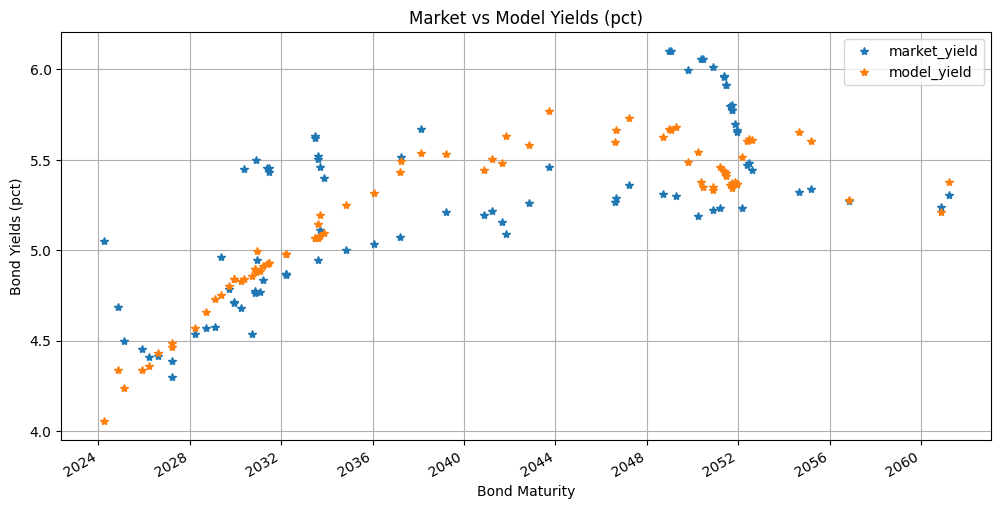

In [26]:
plt = vz_df.plot(x='maturity', y = ['market_yield', 'model_yield'], figsize = (12, 6), title = "Market vs Model Yields (pct)", grid=True, style='*')
plt.set_ylabel('Bond Yields (pct)')
plt.set_xlabel('Bond Maturity')


Text(0.5, 0, 'Bond Maturity')

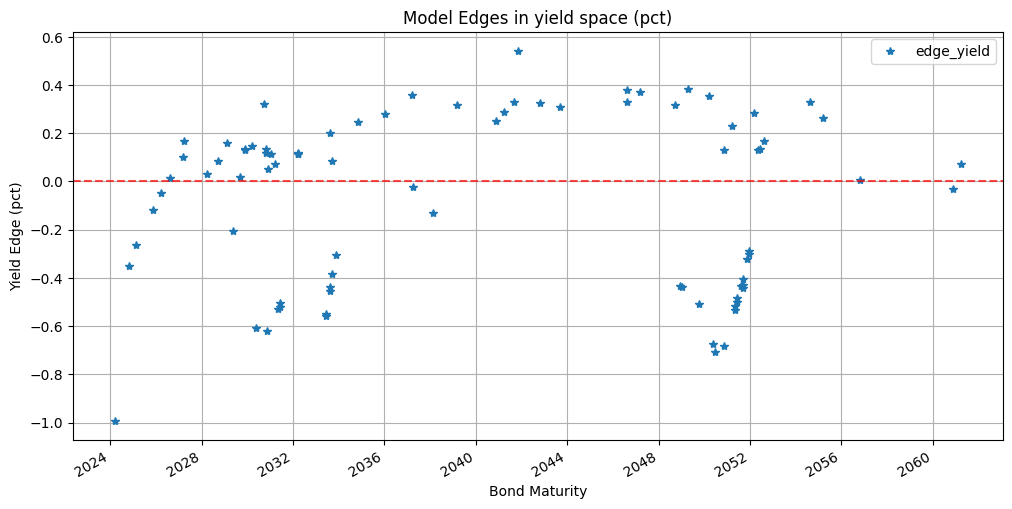

In [27]:
plt = vz_df.plot(x='maturity', y = ['edge_yield'], figsize = (12, 6), title = "Model Edges in yield space (pct)", grid=True, style='*')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.set_ylabel('Yield Edge (pct)')
plt.set_xlabel('Bond Maturity')


# Problem 4: Pricing bonds in the Merton Structural Credit Model
## Follow Lecture 4, Section 2 "Structural Credit Default Models"

## a. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%

Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.


\begin{align}
E_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[\left(A_{T}-K\right)^{+}|\mathcal{F}_{0}\right]
\end{align}

\begin{align}
=Call\left(A_{0},K,T,\sigma_{A},r,\right)
\end{align}

\begin{align}
=A_{0}\cdot\Phi\left(d_{+}\right)-e^{-r\cdot T}\cdot K\cdot\Phi\left(d_{-}\right)
\end{align}

\begin{align}
d_{\pm}=\frac{-\log\left(L_{0}\right)+\left(r\pm\frac{1}{2}\sigma_{A}^{2}\right)\cdot T}{\sigma_{A}\cdot\sqrt{T}}
\end{align}


In [28]:
from scipy.stats import norm

def calc_d1_d2(A,r,sigma_A,T,L):
    d1 = (-np.log(L/A) + (r + 0.5 * sigma_A**2)* T ) / (sigma_A * np.sqrt(T))
    d2 = (-np.log(L/A) + (r - 0.5 * sigma_A**2)* T ) / (sigma_A * np.sqrt(T))    
    return (d1, d2)

def fairValueEquity(A,r,sigma_A,T,L):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,L)
    E0  = A * norm.cdf(d1) - np.exp(-r * T) * L * norm.cdf(d2)
    return E0


In [29]:
K = 100
A = 125
r = 0.04
T = 5
sigma_A = 0.2

E0 = fairValueEquity(A, r, sigma_A, T, K)
print('Fair value of equity at time 0 (MM):', round(E0, 3))

Fair value of equity at time 0 (MM): 47.234


## b. Risky Bond Valuation (Fair Value of Liabilities)

Compute the fair value of the risky bond.

\begin{align}
B_{0}=e^{-r\cdot T}\cdot\mathbb{E}\left[K-\left(K-A_{T}\right)^{+}|\mathcal{F}_{0}\right]
\end{align}

\begin{align}
=e^{-r\cdot T}\cdot K-Put\left(A_{0},K,T,\sigma_{A},r,\right)
\end{align}

\begin{align}
=A_{0}\cdot\Phi\left(-d_{+}\right)+e^{-r\cdot T}\cdot K\cdot\Phi\left(d_{-}\right)
\end{align}


In [30]:
def fairValueRiskyBond(A,r,sigma_A,T,L):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,L)
    B0  = A * norm.cdf(-d1) + L * np.exp(-r * T) * norm.cdf(d2)
    
    return B0

In [31]:
B0 = fairValueRiskyBond(A, r, sigma_A, T, K)
print('Fair value of risky bond at time 0 (MM):', round(B0, 3))

print('Check that E0 and B0 add up to A0 (MM):', round(E0 + B0, 3), '=', A)

Fair value of risky bond at time 0 (MM): 77.766
Check that E0 and B0 add up to A0 (MM): 125.0 = 125


## c. Flat yield, spread and hazard rate

Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default

Plot bond credit spreads as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

d1, d2 = calc_d1_d2(A0, r, sigma_A, T, K)

In [32]:
def defaultProbability(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    default_prob = norm.cdf(-d2)
    
    return default_prob

def survivalProbability(A,r,sigma_A,T,L):
    return(1 - defaultProbability(A,r,sigma_A,T,L))

def distanceToDefault(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)        
    return(d2)

def riskyBondYield(A,r,sigma_A,T,K):
    B0 = fairValueRiskyBond(A,r,sigma_A,T,K)
    bond_yield = - np.log(B0/K) / T       
    return bond_yield

def riskyBondCreditSpread(A,r,sigma_A,T,K):
    bond_yield = riskyBondYield(A,r,sigma_A,T,K)    
    bond_credit_spread = bond_yield - r
    return bond_credit_spread

def flatHazardRate(A,r,sigma_A,T,K):
    survival_prob = survivalProbability(A,r,sigma_A,T,K)
    flat_hazard_rate = - np.log(survival_prob) / T
    return flat_hazard_rate

def expectedRecoveryRate(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)    
    exp_rec_rate = A / K * norm.cdf(-d1)/norm.cdf(-d2)
    return exp_rec_rate


In [33]:
dist_to_default = distanceToDefault(A,r,sigma_A,T,K)
default_prob = defaultProbability(A,r,sigma_A,T,K)
survival_prob = survivalProbability(A,r,sigma_A,T,K)
bond_yield = riskyBondYield(A,r,sigma_A,T,K) * 1e2
bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K) * 1e4
flat_hazard_rate = flatHazardRate(A,r,sigma_A,T,K) * 1e4
exp_rec_rate = expectedRecoveryRate(A,r,sigma_A,T,K) * 1e2

print('Distance to Default:', round(dist_to_default,3))
print('Default Probability:', round(default_prob, 3))
print('Survival Probability:', round(survival_prob, 3))
print('Bond yield (pct):', round(bond_yield, 3))
print('Bond credit spread (bps):', round(bond_credit_spread, 2))
print('Flat Hazard Rate (bps):', round(flat_hazard_rate, 2))
print('Expected Recovery Rate R (pct):', round(exp_rec_rate, 2))

Distance to Default: 0.723
Default Probability: 0.235
Survival Probability: 0.765
Bond yield (pct): 5.029
Bond credit spread (bps): 102.94
Flat Hazard Rate (bps): 535.69
Expected Recovery Rate R (pct): 64.39


Text(0, 0.5, 'Credit Spreads (bps)')

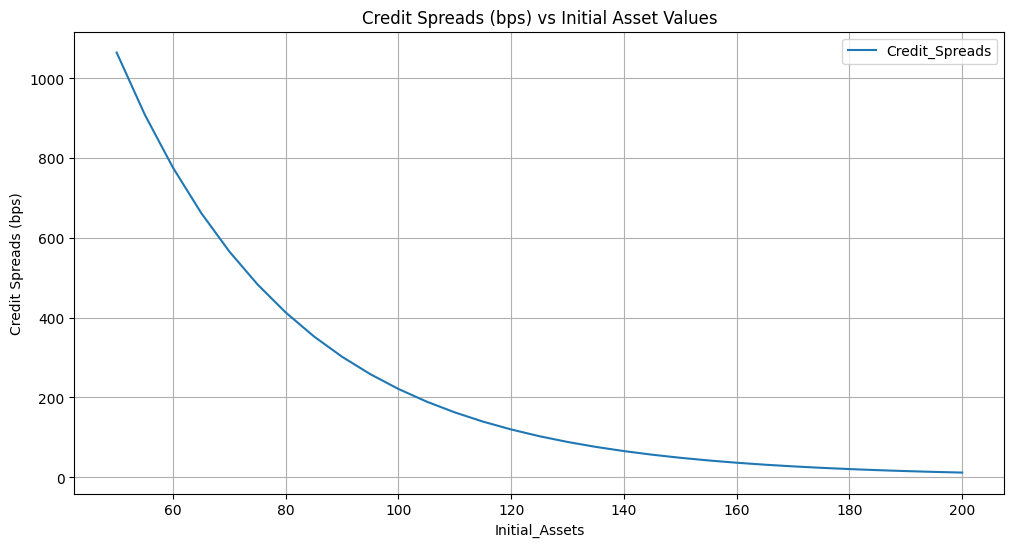

In [34]:
asset_values = [x for x in range(50,205,5)]
credit_spreads = [riskyBondCreditSpread(a,r,sigma_A,T,K) * 1e4 for a in asset_values]
grid_df = pd.DataFrame(data={'Initial_Assets': asset_values, 'Credit_Spreads': credit_spreads})  
grid_df.set_index("Initial_Assets", inplace = True)

plt = grid_df.plot(figsize = (12, 6), title = "Credit Spreads (bps) vs Initial Asset Values", grid=True)
plt.set_ylabel('Credit Spreads (bps)')

## d. Equity volatility

Compute the Equity Volatility.

What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?

Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

 

In [35]:
def equityVolatility(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)    
    E0 = fairValueEquity(A,r,sigma_A,T,K)    
    sigma_E = (A / E0) * norm.cdf(d1) * sigma_A
    return sigma_E


In [36]:
equity_vol = equityVolatility(A,r,sigma_A,T,K) * 100

print('Equity Volatility (pct):', round(equity_vol, 2))

Equity Volatility (pct): 46.52


Text(0, 0.5, 'Equity Volatility (pct)')

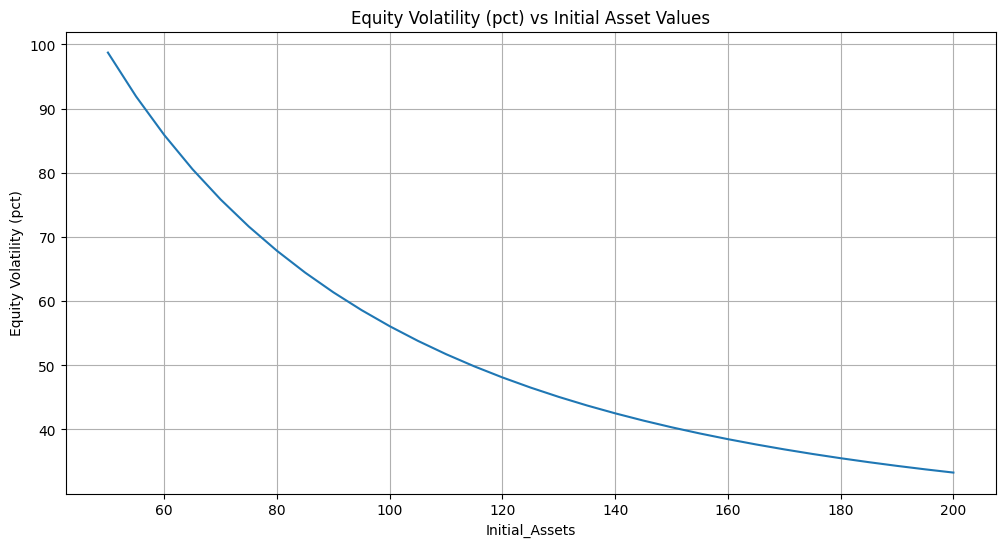

In [37]:
asset_values = [x for x in range(50,205,5)]
equity_volatilities = [equityVolatility(a,r,sigma_A,T,K) * 1e2 for a in asset_values]
exp_recovery_rates = [expectedRecoveryRate(a,r,sigma_A,T,K) * 1e2 for a in asset_values]

grid_df['Equity_Vol'] = equity_volatilities

plt = grid_df['Equity_Vol'].plot(figsize = (12, 6), title = "Equity Volatility (pct) vs Initial Asset Values", grid=True)
plt.set_ylabel('Equity Volatility (pct)')

Text(0, 0.5, 'Expected Recovery Rate (pct)')

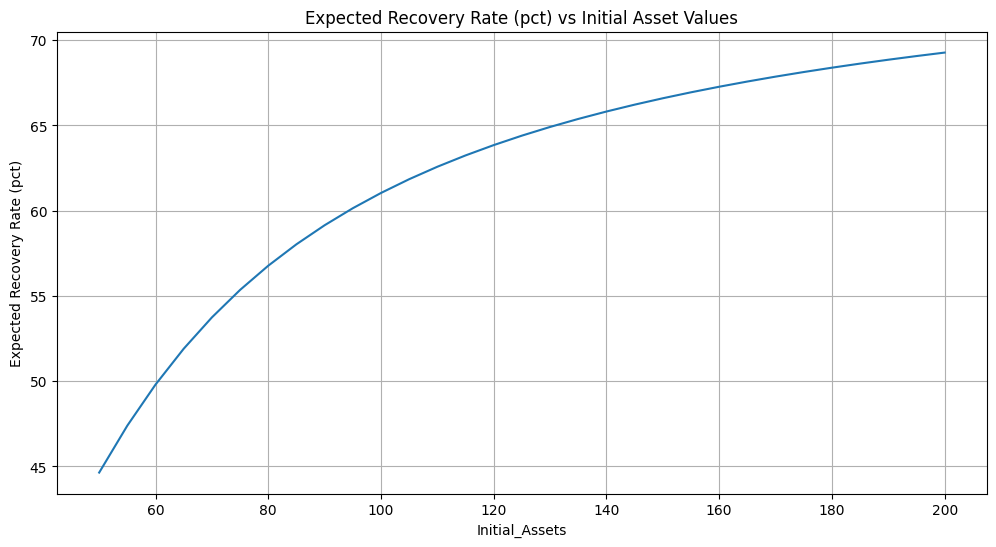

In [38]:
grid_df['Exp_Rec_Rate'] = exp_recovery_rates

plt = grid_df['Exp_Rec_Rate'].plot(figsize = (12, 6), title = "Expected Recovery Rate (pct) vs Initial Asset Values", grid=True)
plt.set_ylabel('Expected Recovery Rate (pct)')